In [2]:
import sys
from pathlib import Path

# Add the project root to the Python path
sys.path.append(str(Path(__file__).parent.parent))

import pandas as pd
from pymilvus import MilvusClient
from sklearn.model_selection import train_test_split
from utils.inference_utils import generate_TL_embeddings, load_model_TL, preprocess_input
from transformers import DistilBertTokenizer
from TL_validation import TL_validation
from dataloader.custom_dataset import Custom_Inference_TL_Dataset_DB
from torch.utils.data import DataLoader

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

## GENERATE MODEL EMBEDDINGS FOR TRAIN (10%) AND TEST (100%)

In [2]:
model_path = '/Users/francesccarandellverdaguer/fairyTaleAI/Checkpoints/TL100EpochsMean.pt'
dataset_sentences = '/Users/francesccarandellverdaguer/fairyTaleAI/dataset/dataset_sentences_cleaned.csv'
processor = TL_validation(model_path, dataset_sentences)
dataset_sentences = pd.read_csv(dataset_sentences)
dataset_csv = pd.read_csv('/Users/francesccarandellverdaguer/fairyTaleAI/dataset/merged_stories_full.csv')
random_state = 123  # We will be testing the Test set defined during training
val_size = 0.1
test_size = 0.1
train, val_test = train_test_split(dataset_csv, test_size=0.2, random_state=random_state)
val, test = train_test_split(val_test, test_size=0.5, random_state=random_state)
train_data = dataset_sentences[dataset_sentences.Title.isin(train.Title.unique())]
test_data = dataset_sentences[dataset_sentences.Title.isin(test.Title.unique())]



/opt/miniconda3/envs/fAIrytale/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# text test: 12019


/opt/miniconda3/envs/fAIrytale/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
### TRAIN SET ###

random_train_data = train_data.sample(n=int(len(train_data)*0.1), random_state=123) # we will take 10% of the embeddings

dataset = Custom_Inference_TL_Dataset_DB(random_train_data, processor.tokenizer, 512)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False, drop_last=False)
id_counter = 0

rows = []
for step, data in enumerate(dataloader):
    sentence_embeddings = generate_TL_embeddings(data, processor.model)  # Generate embeddings
    embeddings = [sentence_embeddings[i].tolist() for i in range(len(sentence_embeddings))]
    texts = [data['sentence'][i] for i in range(len(sentence_embeddings))]
    titles = [data['title'][i] for i in range(len(sentence_embeddings))]
            
    #inputs = preprocess_input(str(row['Sentence']), processor.tokenizer, isBERT=True)
    #query_embedding = generate_TL_embeddings(inputs, processor.model).squeeze().tolist()
    for r in range(len(embeddings)):
        row = {
            'name': texts[r],
            'title': titles[r],  
            'embedding': embeddings[r],  
        }
        rows.append(row)

    df = pd.DataFrame(rows)

    df.to_csv('embeddings_train_set.csv', index=False)
    print(str(100*step+100),'/',len(random_train_data))

100 / 9925
200 / 9925
300 / 9925
400 / 9925
500 / 9925
600 / 9925
700 / 9925
800 / 9925
900 / 9925
1000 / 9925
1100 / 9925
1200 / 9925
1300 / 9925
1400 / 9925
1500 / 9925
1600 / 9925
1700 / 9925
1800 / 9925
1900 / 9925
2000 / 9925
2100 / 9925
2200 / 9925
2300 / 9925
2400 / 9925
2500 / 9925
2600 / 9925
2700 / 9925
2800 / 9925
2900 / 9925
3000 / 9925
3100 / 9925
3200 / 9925
3300 / 9925
3400 / 9925
3500 / 9925
3600 / 9925
3700 / 9925
3800 / 9925
3900 / 9925
4000 / 9925
4100 / 9925
4200 / 9925
4300 / 9925
4400 / 9925
4500 / 9925
4600 / 9925
4700 / 9925
4800 / 9925
4900 / 9925
5000 / 9925
5100 / 9925
5200 / 9925
5300 / 9925
5400 / 9925
5500 / 9925
5600 / 9925
5700 / 9925
5800 / 9925
5900 / 9925
6000 / 9925
6100 / 9925
6200 / 9925
6300 / 9925
6400 / 9925
6500 / 9925
6600 / 9925
6700 / 9925
6800 / 9925
6900 / 9925
7000 / 9925
7100 / 9925
7200 / 9925
7300 / 9925
7400 / 9925
7500 / 9925
7600 / 9925
7700 / 9925
7800 / 9925
7900 / 9925
8000 / 9925
8100 / 9925
8200 / 9925
8300 / 9925
8400 / 9925
8

In [4]:
### TEST SET ###
dataset = Custom_Inference_TL_Dataset_DB(test_data, processor.tokenizer, 512)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, drop_last=False)
id_counter = 0

rows = []
for step, data in enumerate(dataloader):
    sentence_embeddings = generate_TL_embeddings(data, processor.model)  # Generate embeddings
    embeddings = [sentence_embeddings[i].tolist() for i in range(len(sentence_embeddings))]
    texts = [data['sentence'][i] for i in range(len(sentence_embeddings))]
    titles = [data['title'][i] for i in range(len(sentence_embeddings))]
            
    #inputs = preprocess_input(str(row['Sentence']), processor.tokenizer, isBERT=True)
    #query_embedding = generate_TL_embeddings(inputs, processor.model).squeeze().tolist()
    for r in range(len(embeddings)):
        row = {
            'name': texts[r],
            'title': titles[r],  
            'embedding': embeddings[r],  
        }
        rows.append(row)

    df = pd.DataFrame(rows)

    df.to_csv('embeddings_test_set.csv', index=False)
    print(64*step+64)

64
128
192
256
320
384
448
512
576
640
704
768
832
896
960
1024
1088
1152
1216
1280
1344
1408
1472
1536
1600
1664
1728
1792
1856
1920
1984
2048
2112
2176
2240
2304
2368
2432
2496
2560
2624
2688
2752
2816
2880
2944
3008
3072
3136
3200
3264
3328
3392
3456
3520
3584
3648
3712
3776
3840
3904
3968
4032
4096
4160
4224
4288
4352
4416
4480
4544
4608
4672
4736
4800
4864
4928
4992
5056
5120
5184
5248
5312
5376
5440
5504
5568
5632
5696
5760
5824
5888
5952
6016
6080
6144
6208
6272
6336
6400
6464
6528
6592
6656
6720
6784
6848
6912
6976
7040
7104
7168
7232
7296
7360
7424
7488
7552
7616
7680
7744
7808
7872
7936
8000
8064
8128
8192
8256
8320
8384
8448
8512
8576
8640
8704
8768
8832
8896
8960
9024
9088
9152
9216
9280
9344
9408
9472
9536
9600
9664
9728
9792
9856
9920
9984
10048
10112
10176
10240
10304


## PCA

In [16]:
df_train = pd.read_csv('embeddings_train_set.csv')
df_test = pd.read_csv('embeddings_test_set.csv')

pca = PCA(2)
features = []
for j in range(len(df_train)):
    
    features.append(np.array([float(i) for i in (df_train.iloc[j].embedding[1:-1]).split(',')]))
features_pca = pca.fit_transform(features)
print(pca.explained_variance_ratio_.cumsum())
df_train['PCA_0'] = features_pca[:,0]
df_train['PCA_1'] = features_pca[:,1]

features_test = []
for j in range(len(df_test)):
    
    features_test.append(np.array([float(i) for i in (df_test.iloc[j].embedding[1:-1]).split(',')]))
features_pca_test = pca.fit_transform(features_test)

df_test['PCA_0'] = features_pca_test[:,0]
df_test['PCA_1'] = features_pca_test[:,1]


[0.80654457 0.85550418]


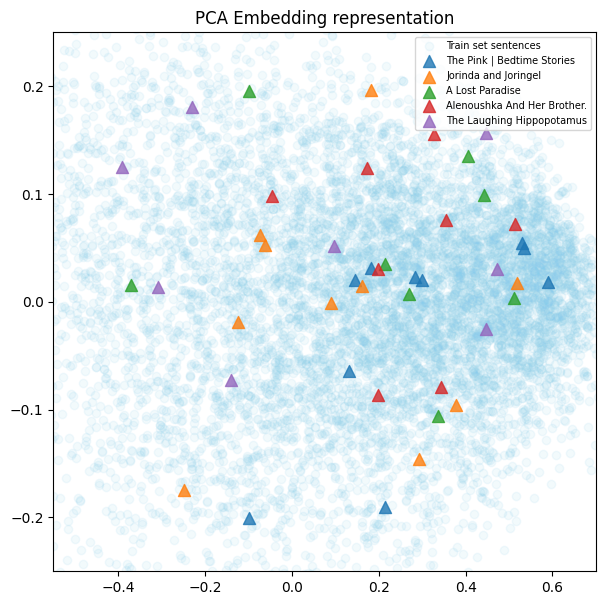

In [19]:
plt.figure(figsize=(7,7))
plt.scatter(df_train['PCA_0'] , df_train['PCA_1'], color = 'skyblue', alpha = 0.1,label='Train set sentences')
ct=0
i=0
sentence = []
while ct < 5:
    title = list(df_test.title.unique())[i]
    sub = df_test[df_test.title==title]
    if len(sub)>=20:
        sentence.append(sub.iloc[0]['name'])
        plt.scatter(sub.iloc[0:10]['PCA_0'] , sub.iloc[0:10]['PCA_1'], alpha = 0.8,s=75,label=title,marker='^')
        ct+=1
    i+=25
    plt.xlim([-0.55,0.7])
    plt.ylim([-0.25,0.25])
plt.legend(fontsize=7)
plt.title('PCA Embedding representation');

In [54]:
list(df_test.title.unique())

['The Pink | Bedtime Stories',
 'Madeline',
 'Pinocchio',
 'Alice in Wonderland',
 'The Lion and the Mouse',
 'The Bremen Town Musicians',
 'Love You Forever',
 'King Midas and the Golden Touch Story',
 'Fuzzy’s Fearless Smile: A Dental Adventure in The Forest',
 'Beneath the Miami Moon A Love Story',
 'The Love Story of The Shepherdess and The Chimney Sweep',
 'The Greek Myth of Hermes',
 'The Bold Live of Benjamin Franklin',
 'The Jungle Book Short Story',
 'The Pied Piper of Hamelin Story',
 'Ali Baba and the Forty Thieves Short Story',
 'Riquet with the Tuft Fairy Tale',
 'The Unfolding Notes of The Heart',
 'The wolf and the seven young kids',
 'Straw, coal, and bean',
 'The louse and the flea',
 'The tailor in heaven',
 'Godfather Death',
 'Snow-white',
 'The dog and the sparrow',
 'Jorinda and Joringel',
 'The poor man and the rich man',
 'The singing, springing lark',
 'The flail from heaven',
 'The blue light',
 'The devil and his grandmother',
 'Ferdinand the faithful',
 'The

## T-SNE

In [20]:
df_train = pd.read_csv('embeddings_train_set.csv')
df_test = pd.read_csv('embeddings_test_set.csv')

features = []
for j in range(len(df_train)):
    
    features.append(np.array([float(i) for i in (df_train.iloc[j].embedding[1:-1]).split(',')]))
    
tsne = TSNE(n_components=2, learning_rate = 20, metric = 'l2', random_state=0)
features_sne = tsne.fit_transform(np.vstack(features))

df_train['PCA_0'] = features_sne[:,0]
df_train['PCA_1'] = features_sne[:,1]

features_test = []
for j in range(len(df_test)):
    
    features_test.append(np.array([float(i) for i in (df_test.iloc[j].embedding[1:-1]).split(',')]))
features_tsne_test = tsne.fit_transform(np.vstack(features_test))

df_test['PCA_0'] = features_tsne_test[:,0]
df_test['PCA_1'] = features_tsne_test[:,1]


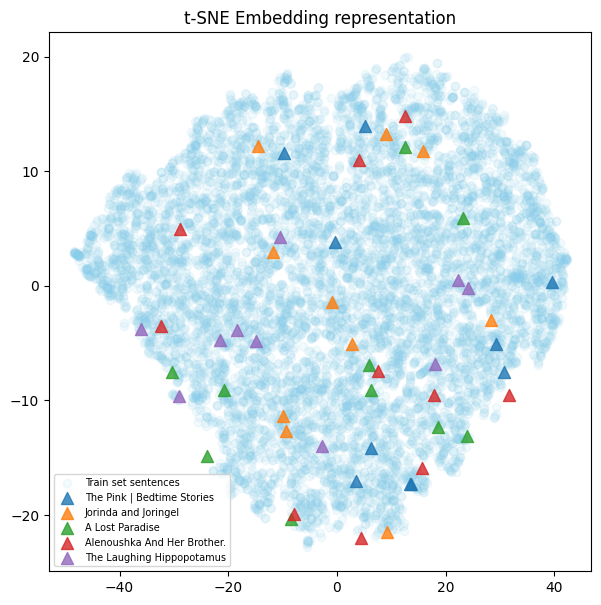

In [21]:
plt.figure(figsize=(7,7))
plt.scatter(df_train['PCA_0'] , df_train['PCA_1'], color = 'skyblue', alpha = 0.1,label='Train set sentences')
ct=0
i=0
sentence = []
while ct < 5:
    title = list(df_test.title.unique())[i]
    sub = df_test[df_test.title==title]
    if len(sub)>=20:
        sentence.append(sub.iloc[0]['name'])
        plt.scatter(sub.iloc[0:10]['PCA_0'] , sub.iloc[0:10]['PCA_1'], alpha = 0.8,s=75,label=title,marker='^')
        ct+=1
    i+=25

plt.legend(fontsize=7)
plt.title('t-SNE Embedding representation');
plt.savefig('t-sne.png')